https://github.com/aldaghri/CMU

Iteration 0 of 3
Code 0
Progress:
100.0 %
Average time= 0.00985350489616394
Average training MSE= 0.00025260693787541
Average MSE= 0.0009117466979773094
Iteration 1 of 3
Code 0
Progress:
100.0 %
Average time= 0.0050866687297821045
Average training MSE= 0.001061392691755007
Average MSE= 0.001631703043716261
Iteration 2 of 3
Code 0
Progress:
100.0 %
Average time= 0.005632766485214233
Average training MSE= 0.0020890246056270282
Average MSE= 0.002276577444398454
Iteration 3 of 3
Code 0
Progress:
100.0 %
Average time= 0.003950037956237793
Average training MSE= 0.0024556374513764554
Average MSE= 0.003163721768279577
Iteration 0 of 8
Progress:
100.0 %
Average time= 0.011494588851928712
Average training MSE= 0.00023391190766225387
Average MSE= 0.0005807434390620823
Iteration 1 of 8
Progress:
100.0 %
Average time= 0.009454853534698486
Average training MSE= 0.000596695945506626
Average MSE= 0.0008973403078431895
Iteration 2 of 8
Progress:
100.0 %
Average time= 0.007566889524459839
Average traini

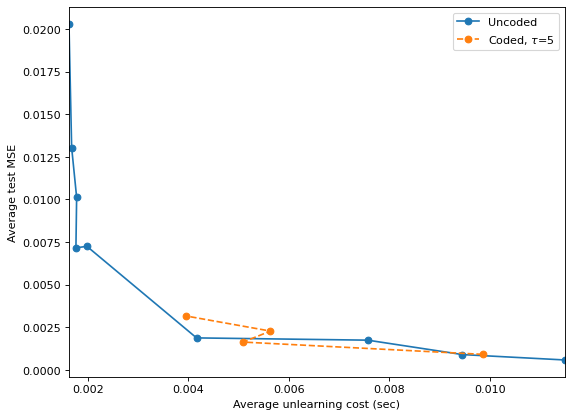

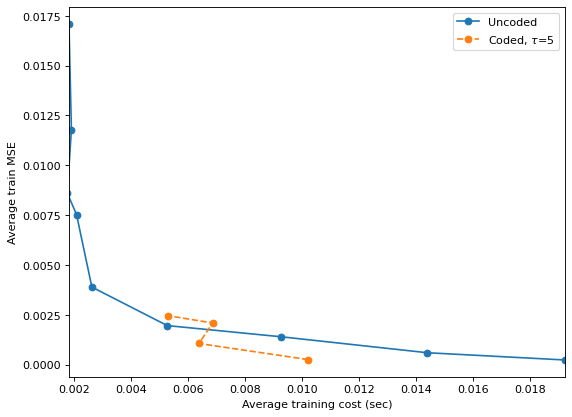

Simulation is done. Figures and results are saved.


In [ ]:
import numpy as np
from numpy import genfromtxt
import math
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import argparse
import sys, os
import csv

def RidgeRegression(x_train, y_train):
    # Set the ridge regression model parameters.
    if Alpha != 0.0:
        reg = linear_model.Ridge(fit_intercept=False, alpha=Alpha, tol=Tol, max_iter=10 ** 10)
    if Alpha == 0.0:
        reg = linear_model.LinearRegression(fit_intercept=False)
    # Train the model and compute the the time.
    start_time = time.time()
    reg.fit(x_train, np.ravel(y_train))
    end_time = time.time()

    return reg.coef_, (end_time - start_time)


def NumberOfShards(Num_training_temp, Num_of_features_temp):
    i = 1
    Num_of_WL_uncoded_temp = []
    while i <= int(Num_training_temp / Num_of_features_temp):
        if Num_training_temp % i == 0:
            Num_of_WL_uncoded_temp.append(i)
        i += 1

    return Num_of_WL_uncoded_temp


def TestLinearModel(x, y, A):
    A_ave = np.mean(A, axis=1)
    y_agg = np.matmul(x, A_ave)
    MSE = mean_squared_error(y_agg, y)

    return MSE


def LinearEncoding(x_uncoded_temp, y_uncoded_temp, G_temp):
    _, WL_temp = np.shape(G_temp)
    x_coded = np.zeros((np.shape(x_uncoded_temp)[1], np.shape(x_uncoded_temp)[2], WL_temp))
    y_coded = np.zeros((np.shape(x_uncoded_temp)[1], WL_temp))

    # Encode the dataset using the matrix G_temp.
    for G_columns in range(WL_temp):
        x_coded_temp = np.zeros((1, np.shape(x_uncoded_temp)[1], np.shape(x_uncoded_temp)[2]))
        y_coded_temp = np.zeros((np.shape(y_uncoded_temp)[1], 1))
        non_zero_ind = np.where((G_temp[:, G_columns]) != 0)[0]

        for ind_temp in range(len(non_zero_ind)):
            x_coded_temp = x_coded_temp + x_uncoded_temp[non_zero_ind[ind_temp]]
            y_coded_temp = y_coded_temp + y_uncoded_temp[non_zero_ind[ind_temp]]

        x_coded[:, :, G_columns] = np.squeeze(x_coded_temp)
        y_coded[:, G_columns] = np.ndarray.flatten(y_coded_temp)

    return x_coded, y_coded


def SampleRemovalCoded(x_coded_p1_temp, y_coded_p1_temp, A_predicted_p1_temp, G_p1_temp, Num_training_temp):
    x_coded_p1_1sample_removed = np.copy(x_coded_p1_temp)
    y_coded_p1_1sample_removed = np.copy(y_coded_p1_temp)
    A_predicted_1sample_removed_p1_temp = np.copy(A_predicted_p1_temp)

    # Locate a sample uniformly at random to remove.
    shards, _ = np.shape(G_p1_temp)
    Num_samples_shards_temp = int(Num_training_temp / shards)
    index_of_removed_sample = np.random.permutation(Num_training_temp)[0]
    shard_number = index_of_removed_sample // Num_samples_shards_temp
    sample_number = (index_of_removed_sample % Num_samples_shards_temp)
    coded_shard_number_p1 = np.where(G_p1_temp[shard_number, :] == 1)[0]

    # Remove a sample from the coded shard.
    x_temp_1sample_removed = np.array(x_coded_p1_1sample_removed[:, :, coded_shard_number_p1[0]])
    x_temp_1sample_removed[sample_number, :] -= x_uncoded[shard_number][sample_number, :]
    x_coded_p1_1sample_removed[:, :, coded_shard_number_p1[0]] = np.copy(x_temp_1sample_removed)

    y_temp_1sample_removed = np.array(y_coded_p1_1sample_removed[:, coded_shard_number_p1[0]])[:, np.newaxis]
    y_temp_1sample_removed[sample_number] -= y_uncoded[shard_number][sample_number, :]
    y_coded_p1_1sample_removed[:, coded_shard_number_p1] = np.copy(y_temp_1sample_removed)

    # Retrain the affected weak learner and update the model.
    A_predicted_1sample_removed_p1_temp[:, coded_shard_number_p1[0]], time_temp11 = \
        RidgeRegression(x_temp_1sample_removed, y_temp_1sample_removed)
    training_time_1sample_removed_p1_temp11 = time_temp11

    return A_predicted_1sample_removed_p1_temp, training_time_1sample_removed_p1_temp11


def SampleRemovalUncoded(x_uncoded_temp, y_uncoded_temp, A_predicted_uncoded_temp, Num_training_temp,
                         Num_of_WL_uncoded_temp):
    x_uncoded_1sample_removed = list(x_uncoded_temp)
    y_uncoded_1sample_removed = list(y_uncoded_temp)
    A_predicted_1sample_removed_uncoded_temp = np.copy(A_predicted_uncoded_temp)

    # Locate a sample uniformly at random to remove.
    Num_samples_shards_temp = int(Num_training_temp / Num_of_WL_uncoded_temp)
    index_of_removed_sample = np.random.permutation(Num_training_temp)[0]
    shard_number = index_of_removed_sample // Num_samples_shards_temp
    sample_number = (index_of_removed_sample % Num_samples_shards_temp)

    # Remove a sample from the uncoded shard.
    x_temp_1sample_removed = np.array(x_uncoded_1sample_removed[shard_number])
    x_temp_1sample_removed = np.delete(x_temp_1sample_removed, sample_number, 0)
    x_uncoded_1sample_removed[shard_number] = np.copy(x_temp_1sample_removed)

    y_temp_1sample_removed = np.array(y_uncoded_1sample_removed[shard_number])
    y_temp_1sample_removed = np.delete(y_temp_1sample_removed, sample_number, 0)
    y_uncoded_1sample_removed[shard_number] = np.copy(y_temp_1sample_removed)

    # Retrain the affected weak learner and update the model.
    x_temp1_del = x_uncoded_1sample_removed[shard_number]
    y_temp1_del = y_uncoded_1sample_removed[shard_number]
    A_predicted_1sample_removed_uncoded_temp[:, shard_number], time_temp21 = RidgeRegression(x_temp1_del, y_temp1_del)
    training_time_1sample_removed_uncoded_temp11 = time_temp21

    return A_predicted_1sample_removed_uncoded_temp, training_time_1sample_removed_uncoded_temp11


def parameters():
    Num_codes = 1
    Tol = 10 ** (-10)
    return Num_codes, Tol


# Import desired parameters and get the dataset.
# parsed = read_options()
Alpha = 0
Code_rate = 5
Num_trials = 200
Synthetic = 1
Sigma = 0.5
Num_features = 10
Num_samples = 2000
Num_test = 300
Random_proj = 0
# D = parsed['D']
Show_progress = 1

Num_codes, Tol = parameters()

if Synthetic == 1:
    # Generate lognormal features and map to a polynomial of degree 3.
    X_original = np.random.lognormal(mean=1.0, sigma=Sigma, size=(Num_samples, Num_features))
    X_original2 = np.power(X_original, 2)
    X_original3 = np.power(X_original, 3)
    X = np.concatenate((X_original, X_original2, X_original3), axis=1)
    beta = np.random.standard_normal(size=(X.shape[1], 1))
    y = np.matmul(X, beta) + np.random.standard_normal(size=(X.shape[0], 1))

if Synthetic != 1:
    Data = genfromtxt('my_dataset.csv', delimiter=',')
    X = np.copy(Data[:, :-1])
    y = np.copy(Data[:, -1])

# Normalize the features and responses to be in [0,1].
X = np.divide((np.subtract(X, np.amin(X,axis=0))), (np.subtract(np.amax(X,axis=0), np.amin(X,axis=0))))
y = np.divide((np.subtract(y, np.amin(y, axis=0))), (np.subtract(np.amax(y, axis=0), np.amin(y, axis=0))))

# Apply random projections on the normalized dataset if desired.
if Random_proj == 1:
    theta = np.random.normal(loc=0.0, scale=np.divide(1, np.sqrt(2.0 * X.shape[1])), size=(X.shape[1], D))
    beta = np.random.uniform(low=(-math.pi), high=math.pi, size=(1, D))
    X = np.cos(np.add(np.matmul(X, theta), beta))

Num_total, Num_of_features = X.shape
Num_training = Num_total - Num_test
Num_of_WL_uncoded = NumberOfShards(Num_training, Num_of_features)[:-1]
Num_of_WL_coded = NumberOfShards(np.divide(Num_training, Code_rate), Num_of_features)[:-1]

# Coded unlearning experiments simulations.
Code_rate_all = Code_rate * np.ones(len(Num_of_WL_coded))

# Initialize empty vectors for the experiments.
p1_average = []
MSE_p1 = []
std_MSE_p1 = []

training_time_p1 = []
MSE_training_p1 = []
std_MSE_training_p1 = []

cost_1sample_removed_p1 = []
MSE_1sample_removed_p1 = []
std_MSE_1sample_removed_p1 = []

for i123 in range(500000):
    pass

for iter in range(len(Num_of_WL_coded)):
    print('Iteration', iter, 'of', (len(Num_of_WL_coded) - 1))
    p1_temp = []
    MSE_training_p11 = np.zeros((Num_trials, Num_codes))
    MSE_p11 = np.zeros((Num_trials, Num_codes))
    MSE_1sample_removed_p11 = np.zeros((Num_trials, Num_codes))
    training_time_p11 = np.zeros((Num_trials, Num_codes))
    cost_1sample_removed_p11 = np.zeros((Num_trials, Num_codes))

    for codes in range(Num_codes):

        print('Code', codes)
        CHECK = 0

        # Randomly generate the encoding matrix G with minimum density.
        while CHECK != 1:
            G_p1_temp1 = np.zeros((int(Code_rate_all[iter] * Num_of_WL_coded[iter]), int(Num_of_WL_coded[iter])))
            e1 = np.append(np.zeros(Num_of_WL_coded[iter] - 1), 1)
            indx_of_zero_rows = np.where(np.sum(G_p1_temp1, axis=1) == 0)[0]

            for j in range(len(indx_of_zero_rows)):
                G_p1_temp1[indx_of_zero_rows[j], :] = np.random.permutation(e1)

            rankG = (np.linalg.matrix_rank(G_p1_temp1) == int(Num_of_WL_coded[iter]))
            Num_zero_columns = len(np.where(np.sum(G_p1_temp1, axis=1) == 0)[0]) == 0
            CHECK = ((rankG * 1 == 1) and (Num_zero_columns * 1 == 1))

        G_p1 = G_p1_temp1
        p1_temp.append(np.sum(G_p1) / (np.size(G_p1)))

        # Initialize empty vectors for the experiment of the same number of shards.
        MSE_p1_temp = []
        MSE_training_p1_temp = []
        training_time_p11_temp = []
        MSE_1sample_removed_p1_temp = []
        cost_1sample_removed_p11_temp = []

        # Run the expreiment (Num_trials) times.
        print("Progress:")
        for trials in range(Num_trials):
            print(round((trials + 1) / Num_trials * 100, 3), "%", end='\r')

            # Shuffle the dataset and splitting into training and testing.
            Permutation = np.random.permutation(Num_total)
            Shuffled_x_all = np.copy(X[Permutation, :])
            Shuffled_y_all = np.copy(y[Permutation])

            Shuffled_x_test = np.copy(Shuffled_x_all[-Num_test:, :])
            Shuffled_y_test = np.reshape(Shuffled_y_all[-Num_test:], (Num_test, 1))
            Shuffled_x = np.copy(Shuffled_x_all[0:Num_training])
            Shuffled_y = np.reshape(Shuffled_y_all[0:Num_training], (Num_training, 1))

            # Split the training dataset into shards.
            x_uncoded = np.vsplit(Shuffled_x, int(Code_rate * Num_of_WL_coded[iter]))
            y_uncoded = np.vsplit(Shuffled_y, int(Code_rate * Num_of_WL_coded[iter]))

            # Encode the shards using the matrix G.
            x_coded_p1, y_coded_p1 = LinearEncoding(x_uncoded, y_uncoded, G_p1)

            # Train weak learners.
            A_predicted_p1 = np.zeros((np.shape(x_uncoded)[2], Num_of_WL_coded[iter]))
            training_time_p1_temp = []

            for WL in range(Num_of_WL_coded[iter]):
                x_temp1 = np.copy(x_coded_p1[:, :, WL])
                y_temp1 = np.copy(y_coded_p1[:, WL])
                A_predicted_p1[:, WL], time_temp1 = RidgeRegression(x_temp1, y_temp1[:, np.newaxis])
                training_time_p1_temp.append(time_temp1)

            MSE_training_p1_temp.append(TestLinearModel(Shuffled_x, Shuffled_y, A_predicted_p1))
            MSE_p1_temp.append(TestLinearModel(Shuffled_x_test, Shuffled_y_test, A_predicted_p1))
            training_time_p11_temp.append(np.mean(training_time_p1_temp))

            # Unlearn a sample chosen uniformly at random from the training dataset.
            A_predicted_1sample_removed_p1, training_time_1sample_removed_p1_temp1 = \
                SampleRemovalCoded(x_coded_p1, y_coded_p1, A_predicted_p1, G_p1, Num_training)
            cost_1sample_removed_p11_temp.append(training_time_1sample_removed_p1_temp1)
            MSE_1sample_removed_p1_temp.append(
                TestLinearModel(Shuffled_x_test, Shuffled_y_test, A_predicted_1sample_removed_p1))

        MSE_p11[:, codes] = np.copy(MSE_p1_temp)
        MSE_1sample_removed_p11[:, codes] = np.copy(MSE_1sample_removed_p1_temp)
        MSE_training_p11[:, codes] = np.copy(MSE_training_p1_temp)
        training_time_p11[:, codes] = np.copy(training_time_p11_temp)
        cost_1sample_removed_p11[:, codes] = np.copy(cost_1sample_removed_p11_temp)

    # Compute the desired metrics for the shard size.
    p1_average.append((np.mean(p1_temp)))
    MSE_p1.append(np.mean(MSE_p11))
    std_MSE_p1.append(np.std(MSE_p11))

    MSE_training_p1.append(np.mean(MSE_training_p11))
    std_MSE_training_p1.append(np.std(MSE_training_p11))
    training_time_p1.append(np.mean(training_time_p11))

    MSE_1sample_removed_p1.append(np.mean(MSE_1sample_removed_p11))
    std_MSE_1sample_removed_p1.append(np.std(MSE_1sample_removed_p11))
    cost_1sample_removed_p1.append(np.mean(cost_1sample_removed_p11))

    print('\nAverage time=', np.mean(cost_1sample_removed_p11))
    print('Average training MSE=', np.mean(MSE_training_p11))
    print('Average MSE=', np.mean(MSE_1sample_removed_p11))

del iter, x_uncoded, y_uncoded

# Uncoded unlearning experiments simulations.

MSE_uncoded = []
std_MSE_uncoded = []

training_time_uncoded = []
MSE_training_uncoded = []
std_MSE_training_uncoded = []

MSE_1sample_removed_uncoded = []
cost_1sample_removed_uncoded = []
std_MSE_1sample_removed_uncoded = []

for iter in range(len(Num_of_WL_uncoded)):
    print('Iteration', iter, 'of', (len(Num_of_WL_uncoded) - 1))
    training_time_uncoded1 = []
    MSE_training_uncoded1_temp = []
    MSE_uncoded1_temp = []

    MSE_1sample_removed_uncoded_temp = []
    cost_1sample_removed_uncoded1_temp = []

    # Run the expreiments (Num_trials) times.
    print("Progress:")
    for trials in range(Num_trials):
        print(round((trials + 1) / Num_trials * 100, 3), "%", end='\r')

        # Shuffle the dataset and splitting into training and testing.
        Permutation = np.random.permutation(Num_total)
        Shuffled_x_all = np.copy(X[Permutation, :])
        Shuffled_y_all = np.copy(y[Permutation])

        Shuffled_x_test = np.copy(Shuffled_x_all[-Num_test:, :])
        Shuffled_y_test = np.reshape(Shuffled_y_all[-Num_test:], (Num_test, 1))
        Shuffled_x = np.copy(Shuffled_x_all[0:Num_training])
        Shuffled_y = np.reshape(Shuffled_y_all[0:Num_training], (Num_training, 1))

        # Split the training dataset into shards.
        x_uncoded = np.vsplit(Shuffled_x, int(Num_of_WL_uncoded[iter]))
        y_uncoded = np.vsplit(Shuffled_y, int(Num_of_WL_uncoded[iter]))

        # Train weak learners.
        A_predicted_uncoded = np.zeros((np.shape(x_uncoded)[2], Num_of_WL_uncoded[iter]))
        training_time_uncoded_temp = []
        for WL in range(Num_of_WL_uncoded[iter]):
            x_temp1 = list(x_uncoded[WL])
            y_temp1 = list(y_uncoded[WL])

            A_predicted_uncoded[:, WL], time_temp3 = RidgeRegression(x_temp1, y_temp1)
            training_time_uncoded_temp.append(time_temp3)

        training_time_uncoded1.append(np.mean(training_time_uncoded_temp))
        MSE_uncoded1_temp.append(TestLinearModel(Shuffled_x_test, Shuffled_y_test, A_predicted_uncoded))
        MSE_training_uncoded1_temp.append(TestLinearModel(Shuffled_x, Shuffled_y, A_predicted_uncoded))

        # Unlearn a sample chosen uniformly at random from the dataset.
        A_predicted_1sample_removed_uncoded, training_time_1sample_removed_uncoded_temp1 = SampleRemovalUncoded(
            x_uncoded, y_uncoded, A_predicted_uncoded, Num_training, Num_of_WL_uncoded[iter])
        cost_1sample_removed_uncoded1_temp.append(training_time_1sample_removed_uncoded_temp1)
        MSE_1sample_removed_uncoded_temp.append(
            TestLinearModel(Shuffled_x_test, Shuffled_y_test, A_predicted_1sample_removed_uncoded))

    # Compute the desired metrics for the shard size.
    MSE_uncoded.append(np.mean(MSE_uncoded1_temp))
    std_MSE_uncoded.append(np.std(MSE_uncoded1_temp))

    MSE_training_uncoded.append(np.mean(MSE_training_uncoded1_temp))
    std_MSE_training_uncoded.append(np.std(MSE_training_uncoded1_temp))
    training_time_uncoded.append(np.mean(training_time_uncoded1))

    MSE_1sample_removed_uncoded.append(np.mean(MSE_1sample_removed_uncoded_temp))
    std_MSE_1sample_removed_uncoded.append(np.std(MSE_1sample_removed_uncoded_temp))
    cost_1sample_removed_uncoded.append(np.mean(cost_1sample_removed_uncoded1_temp))

    print('\nAverage time=', np.mean(cost_1sample_removed_uncoded1_temp))
    print('Average training MSE=', np.mean(MSE_training_uncoded1_temp))
    print('Average MSE=', np.mean(MSE_1sample_removed_uncoded_temp))

# Plot the trade-offs for training and testing.
mpl.rcParams['figure.dpi'] = 80
plt.rcParams["figure.figsize"] = (8, 6)
fig_test, ax_test = plt.subplots()
l1, = ax_test.plot(cost_1sample_removed_uncoded, MSE_1sample_removed_uncoded, '-o')
l2, = ax_test.plot(cost_1sample_removed_p1, MSE_1sample_removed_p1, '--o')

ax_test.legend((l1, l2), ('Uncoded', r'Coded, $\tau$=' + str(Code_rate)), loc='upper right', shadow=False)
ax_test.set_xlabel('Average unlearning cost (sec)')
ax_test.set_ylabel('Average test MSE')
plt.xlim([np.minimum(cost_1sample_removed_uncoded[-1], cost_1sample_removed_p1[-1]), cost_1sample_removed_uncoded[0]])
plt.savefig('Test_tradeoff.png')
plt.show()

mpl.rcParams['figure.dpi'] = 80
plt.rcParams["figure.figsize"] = (8, 6)
fig_train, ax_train = plt.subplots()
l3, = ax_train.plot(training_time_uncoded, MSE_training_uncoded, '-o')
l4, = ax_train.plot(training_time_p1, MSE_training_p1, '--o')

ax_train.legend((l3, l4), ('Uncoded', r'Coded, $\tau$=' + str(Code_rate)), loc='upper right', shadow=False)
ax_train.set_xlabel('Average training cost (sec)')
ax_train.set_ylabel('Average train MSE')
plt.xlim([np.minimum(training_time_uncoded[-1], training_time_p1[-1]), training_time_uncoded[0]])
plt.savefig('Train_tradeoff.png')
plt.show()

# Writing the output to CSV file
dict = {'cost_1sample_removed_uncoded': cost_1sample_removed_uncoded,
        'MSE_1sample_removed_uncoded': MSE_1sample_removed_uncoded,
        'std_MSE_1sample_removed_uncoded':std_MSE_1sample_removed_uncoded,
        'training_time_uncoded': training_time_uncoded,
        'MSE_training_uncoded': MSE_training_uncoded,
        'std_MSE_training_uncoded': std_MSE_training_uncoded,
        'cost_1sample_removed_p1': cost_1sample_removed_p1,
        'MSE_1sample_removed_p1': MSE_1sample_removed_p1,
        'std_MSE_1sample_removed_p1': std_MSE_1sample_removed_p1,
        'training_time_p1': training_time_p1,
        'MSE_training_p1': MSE_training_p1,
        'std_MSE_training_p1': std_MSE_training_p1,
        'Num_trials': [Num_trials]}

w = csv.writer(open("Output.csv", "w"))
for var, val in dict.items():
    temp = [var]
    for item in range(len(val)):
        temp.append(val[item])
    w.writerow(temp)

# enablePrint()
print('Simulation is done. Figures and results are saved.')
